# Part 2: Random Forest Classifier

This lab is a countnuation of a previous notebook in which all the feature selection and data cleaning was done. 

The data from this notebook can be found on the kaggle competition page. Here is the description of the challenge: 

The Inter-American Development Bank is asking the Kaggle community for help with income qualification for some of the world's poorest families. Are you up for the challenge?

Here's the backstory: Many social programs have a hard time making sure the right people are given enough aid. It’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.

In Latin America, one popular method uses an algorithm to verify income qualification. It’s called the Proxy Means Test (or PMT). With PMT, agencies use a model that considers a family’s observable household attributes like the material of their walls and ceiling, or the assets found in the home to classify them and predict their level of need.

While this is an improvement, accuracy remains a problem as the region’s population grows and poverty declines.

To improve on PMT, the IDB (the largest source of development financing for Latin America and the Caribbean) has turned to the Kaggle community. They believe that new methods beyond traditional econometrics, based on a dataset of Costa Rican household characteristics, might help improve PMT’s performance.

Beyond Costa Rica, many countries face this same problem of inaccurately assessing social need. If Kagglers can generate an improvement, the new algorithm could be implemented in other countries around the world.

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', -1)

## Create Random Forest  Model

We will use the Random Forest Classifier for this problem. The Random Forest Classifier created multiple Decision Trees and makes predictions based on a composite of the results of those decision trees. We will also import packages to help us preform cross validation and calculate the f1 score, since that is the metric used to grade our model. 

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold

Import our data and split the 'Target' variable from the rest of the dataframe. I have also imported StratifiedKFold which will allow use to do cross validation. It differs from regular Kfold in that it always contains samples from all the Target groups in both the validation set and the training set. 

In [70]:
df = pd.read_csv('cleaned_household_data.csv').set_index('idhogar')

In [71]:
skf = StratifiedKFold(n_splits=5)

df_X = df.drop(columns = ['Target'], axis = 1)
df_y = df[['Target']]


In [72]:
def cross_val(model):
    f1_scores = []
    for train_index, valid_index in skf.split(df_X, df_y):
        train_X, train_y = df_X.iloc[train_index], df_y.iloc[train_index]
        valid_X, valid_y = df_X.iloc[valid_index], df_y.iloc[valid_index]
    
        model.fit(train_X, train_y)
        y_pred = model.predict(valid_X)
        
        f1_scores.append(f1_score(valid_y,y_pred,average = 'macro'))
    
    return f1_scores
        

In our next cell we will tune the hyper parameter. It is important that you run this cell multiple times for each tunable hyperparameter, and change the lines I have highlighted with the comments

In [ ]:
n_estimators = [500, 750, 1000, 1500, 2000]
max_depth = [3,5,10,20,30,40, None]
min_samples_leaf = [1,2,3,4,8,10,20]
max_features = ['sqrt', 'log2', .05,.1,.25,.33,.5,.75]
min_impurity_decrease = [0, .0005, .005, .5, 1, 2, 10]
max_leaf_nodes = [10, 100, 1000, None]


mean_score= []
std_score = []

metric_list = min_impurity_decrease  #change this variables and run again 

for i in metric_list:  
    rf = RandomForestClassifier(n_estimators=750,
                              max_depth=20,  
                              min_samples_leaf=2,
                              max_features=.5, 
                              min_impurity_decrease = i, #move the i to match variables tuning for
                              max_leaf_nodes = None,
                              random_state=42,
                               class_weight = 'balanced')
    
    mean_score.append(np.mean(cross_val(rf)))
    std_score.append(np.std(cross_val(rf)))

scores = pd.DataFrame(data = {'metric':metric_list, 'mean':mean_score, 'Std. Dev.':std_score})
scores

Now we will split our dataset into a validation set and training set. While this can be done to look for tweaks to made in the model, I did not do that here. Instead, I did it to take a look at the confusion matrix to get a better understanding of our models predictive ability. 

In [34]:
rand_split = np.random.rand(len(df))  
train_list = rand_split < 0.7
valid_list = rand_split >= 0.7

train_X = df_X.iloc[train_list]
train_y = df_y.iloc[train_list]

valid_X = df_X.iloc[valid_list]
valid_y = df_y.iloc[valid_list]

In [35]:
rf = RandomForestClassifier(n_estimators=750,
                            max_depth=20,  
                            min_samples_leaf=2,
                            max_features=.5, 
                            min_impurity_decrease = 0,
                            max_leaf_nodes = None,
                            random_state=42,
                            class_weight = 'balanced')

In [36]:
rf.fit(train_X,train_y)

train_pred = rf.predict(train_X)
valid_pred = rf.predict(valid_X)

f1_train = f1_score(train_y,train_pred,average = 'macro')
f1_valid = f1_score(valid_y,valid_pred,average = 'macro')

print(f'Training f1 score: {f1_train}')
print(f'Validation f1 score: {f1_valid}')

Training f1 score: 0.986349820899546
Validation f1 score: 0.3949036820920032


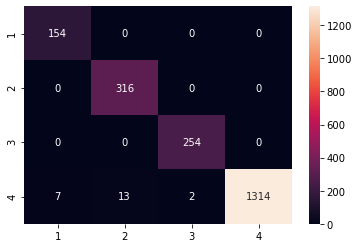

In [37]:
import seaborn as sns

labels = [1,2,3,4]

train_con_mat = confusion_matrix(train_y, train_pred, labels = labels)
train_cm = pd.DataFrame(train_con_mat, index = labels, columns = labels)

sns.heatmap(train_cm,annot=True, fmt = 'g')

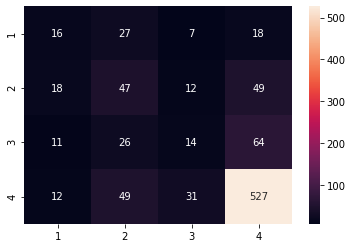

In [38]:
valid_con_mat = confusion_matrix(valid_y, valid_pred, labels = labels)
valid_cm = pd.DataFrame(valid_con_mat, index = labels, columns = labels)

sns.heatmap(valid_cm,annot=True, fmt = 'g')

Unsuprisingly our model preforms significantly better in our training data then validation data. However, our validation score of .39 is not bad (the leader of the competition acheived a score of .45). We can also take a look at our feature importance. 

In [39]:
rf.feature_importances_

df_features = pd.DataFrame(data = {'features' :df_X.columns, 
                                   'importance' :rf.feature_importances_})

df_features.sort_values(by=['importance'], ascending = False)

,features,importance
0,escolari_person,0.132167
10,meaneduc,0.084022
8,dependency,0.062405
11,overcrowding,0.058513
2,rooms,0.050000
14,qmobilephone,0.041023
9,edje,0.037898
15,escolari_head,0.036246
6,hhsize,0.036061
44,Youth,0.033358


Using our confusion matrixes and feature importance list we can make tweaks to the model to improve preformance. That is something I will go back and do in the future. For now we will fit our model on the complete dataset and run our test data. 

In [73]:
rf.fit(df_X,df_y)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=0.5,
                       min_impurity_decrease=0, min_samples_leaf=2,
                       n_estimators=750, random_state=42)

## Run Model on Testing Data

We will import our test data and run our model on it. Then we will take our target values and map them into our raw test data to follow the required format. 

In [74]:
df_Test = pd.read_csv('cleaned_test_data.csv').set_index('idhogar')

In [75]:
Test_predictions = rf.predict(df_Test)

In [76]:
pred_mapping = {k:v for k,v in zip(df_Test.index,Test_predictions)}

In [77]:
data_location= 'test.csv'
submission = pd.read_csv(data_location, low_memory=False)

In [78]:
submission['Target'] = submission['idhogar'].map(pred_mapping)

submission = submission[['idhogar','Target']]
submission = submission.rename(columns = {'idhogar':'id'})

In [79]:
submission.to_csv('submission.csv',index=False)

After submitting to Kaggle, I was able to get a score of .40250. Not a bad score considering that would put me in 253rd place on the leaderboard after my first submssion. Some further tweaks to reduce the number of features fed into the model or oversampling will likley increase that score.

-Fin